### Introduction
Given the enormous volume of the collected data for geological mapping and mineral exploration, it is essential to employ tools suitable to process the data altogether to achieve a fully integrated interpretation. Machine Learning (ML) techniques have been widely used in numerous fields to provide data-related solutions for complex problems. There has been an increasing interest in application of ML in geoscience to help mineral potential mapping and geological mapping. However, complexity and uncertainly associated with geological events differentiate geoscience from other fields of ML applications. It is paramount to frame the geological question to be solved by ML in a realistic manner. Such an approach will help to choose what type of data should be used to feed the model and what to expect from the model output. 

The main objective of this work is to train a model using available exploratory data  and generate maps that  represent prospective areas for gold and base metal exploration.

In [1]:
import os
os.chdir('...\\QGIS') # change pwd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import geopandas as gpd
import glob
import numpy as np
import matplotlib.pyplot as plt
import graphics
from imblearn.combine import SMOTETomek
from sklearn.model_selection import KFold,cross_val_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import mplleaflet
#edit the path in "datadir.py" (located in ...Anaconda3\Lib\site-packages\pyproj).
#Correct path is ".../Anaconda3/Library/share"

## Data import and preparation

### raster data
 Residual magnetic intensity (RMI), bedrock geology map, distance to lineament map, analytic signal of the RMI, and first vertical derivative of RMI are input data that are stored as csv files (Virtual_Ras_1 to 5).

The cell below finds all csv files starting with the term "Virtual", and puts them in a list of dataframes. 

In [4]:
filenames = glob.glob("Virtual*.csv")
dfs = [pd.read_csv(f,header=None, names=['X','Y',f]) for f in filenames]

In [5]:
# merge dataframes and store all information in one dataframe
df_merged=pd.concat(dfs, ignore_index=False,axis=1, join='inner')

In [6]:
# there are duplicated X and Y (UTM coordinates) columns in df_merged. i stores the name of unique columns
_, i = np.unique(df_merged.columns, return_index=True)

In [7]:
# slice the dataframe using the list of unique column names
df=df_merged.iloc[:,i]

In [8]:
# re-ordering the columns to have the X and Y columns first
df=df[['X','Y','Virtual_Ras_1.csv', 'Virtual_Ras_2.csv', 'Virtual_Ras_3.csv',
       'Virtual_Ras_4.csv', 'Virtual_Ras_5.csv']]

# rename column names to a shorter version
df.columns=['X','Y', 'Geol','lin', 'vd','AS','RMI']

In [9]:
df.describe()

,X,Y,Geol,lin,vd,AS,RMI
count,71232.000000,7.123200e+04,71232.000000,7.123200e+04,7.123200e+04,7.123200e+04,7.123200e+04
mean,605962.500000,6.162800e+06,5.760276,-4.640186e+08,-4.330498e+11,-4.609164e+08,-4.330498e+11
std,5542.526313,1.071710e+04,5.637970,4.987076e+08,4.955009e+11,4.984736e+08,4.955009e+11
min,596412.500000,6.144288e+06,0.000000,-1.000000e+09,-1.000000e+12,-1.000000e+09,-1.000000e+12
25%,601187.500000,6.153494e+06,0.000000,-1.000000e+09,-1.000000e+12,-1.000000e+09,-1.000000e+12
50%,605962.500000,6.162800e+06,6.000000,1.000000e+02,-8.115250e-01,1.871340e-01,-1.398065e+02
75%,610737.500000,6.172106e+06,10.000000,6.324560e+02,-9.822480e-02,7.410580e-01,1.353645e+02
max,615512.500000,6.181312e+06,18.000000,4.011230e+03,2.025480e+01,2.050380e+01,4.430880e+03


##### First, null values must be identified and then replaced by np.nan. Because the rasters were created in different programs (QGIS and Geosoft), null values are represented by different numbers (-1.000000e+09 and -1.000000e+12).  

In [10]:
# select the df rows where 'lin' or 'AS' have null values. This selection represents the area outside the area of interest.
# values for the variables (excluding X and Y) are set to np.nan

df.loc[(df['lin']== -1.000000e+09) | (df['AS']== -1.000000e+09) ,['Geol','vd','AS','RMI','lin']]=np.nan # using loc

# rows with null values should not be dropped yet as the array shape must remain intact for plotting

In [11]:
# replace rock types with a few entry in df
df['Geol'].replace({5:6,18:10,3:16},inplace=True)
# convert numeric 'Geol' column to string
df['Geol']=df['Geol'].astype(str)
# np.nan values are converted to string, which must be replaced again.
df['Geol'].replace({'nan':np.nan},inplace=True)

### shapefiles

In [12]:
# location of Sasktchewan known mineral indices and the project outline are stored in two shapefiles
aoi=gpd.read_file('aoi.shp')
SMDI=gpd.read_file('SMDI.shp')

In [13]:
ax = aoi.to_crs({'init': 'epsg:4326'}).boundary.plot(figsize=(6,10))
mplleaflet.display(fig=ax.figure, tiles='esri_natgeo') # or 'esri_aerial'

In [14]:
# select only SMDIs inside the project area
SMDI=gpd.sjoin(SMDI,aoi,op='within')

In [15]:
SMDI['COM_GROUP'].value_counts()

Gold          16
Base Metal    13
Uranium        1
Name: COM_GROUP, dtype: int64

In [16]:
# we are only interested in Gold and Base Metal deposits
SMDI=SMDI[SMDI['COM_GROUP']!= 'Uranium']

In [17]:
# 'Type' of each mineral index for Base Metal and Gold
SMDI.groupby(by=['COM_GROUP','TYPE'])['SMDI'].count()

COM_GROUP   TYPE           
Base Metal  Drillhole           2
            Outcrop Channel     1
            Outcrop grab       10
Gold        Drillhole           1
            Mine                1
            Outcrop Channel     4
            Outcrop grab       10
Name: SMDI, dtype: int64

In [18]:
# only these two columns will be used
SMDI=SMDI[['COM_GROUP','geometry']]

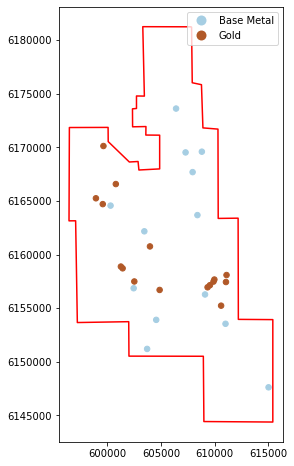

In [19]:
fig,axes=plt.subplots(1,1, figsize=(8,8))
SMDI.plot(ax=axes, markersize=30, column='COM_GROUP',cmap='Paired',label='COM_GROUP', legend=True)
aoi.boundary.plot(ax=axes, color='r')

In [20]:
# The location of mineral indices determines the target areas (labeled as 1 to train the classifier).
# Because they are represented by points, a buffer with radius of 250m is created around them to approximately indicate 
# the footprint of each mineral index. 

SMDI['geom']=SMDI.buffer(250) # was initially named 'buffer' but set_geometry didn't work! So, it was named 'geom' 
SMDI=SMDI.set_geometry('geom') # geometry of SMDI is now polygons

SMDI.drop('geometry', axis=1, inplace=True) # the point column is dropped to avoid confusion

### merging df and SMDI to add SMDI info to df

In [21]:
df=gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X'],df['Y']), crs=32613)
df=gpd.sjoin(df,SMDI, how='left', op='within').drop('index_right', axis=1)
df= df[~df.index.duplicated()] # join added 126 duplicated rows. drop_duplicated didn't work. df_aoi.index
# didn't work either. Because indices were duplicated, too.

In [22]:
# create a column for Gold and Base Metal
df=pd.get_dummies(df,columns=['COM_GROUP'], prefix='', prefix_sep='')

In [23]:
# drop null values to create a dataframe for modeling
# the original dataframe will not be overwritten, because it will be used for plotting.
df_aoi=df.dropna()
aoi_index=df_aoi.index

In [24]:
df_aoi.head()

,X,Y,Geol,lin,vd,AS,RMI,geometry,Base Metal,Gold
262,603412.5,6181212.399,10.0,4011.23,-0.020056,0.155184,28.89220,POINT (603412.500 6181212.399),0,0
263,603512.5,6181212.399,10.0,4005.00,-0.066040,0.180127,16.61910,POINT (603512.500 6181212.399),0,0
264,603612.5,6181212.399,10.0,4001.25,-0.126761,0.197405,2.77560,POINT (603612.500 6181212.399),0,0
265,603712.5,6181212.399,10.0,4000.00,-0.149636,0.198079,-8.25038,POINT (603712.500 6181212.399),0,0
266,603812.5,6181212.399,10.0,4001.25,-0.189492,0.216387,-16.52480,POINT (603812.500 6181212.399),0,0


## plot the data
interpies is a library that can be used to visualize geophysical data grids. It provides most of color scales that are available in Geosoft. To be able to use this library, rasterio must be installed as a prerequisite. More information can be found here:

https://nbviewer.jupyter.org/github/jobar8/interpies/blob/master/notebooks/Displaying_grids.ipynb 

In [25]:
import interpies

In [26]:
# create a mask to indicating the area outside the aoi
mask=np.array(df['lin'].isnull().astype(int)).reshape(371,192)

In [27]:
# create grid files to be used in interpies 
# note that df is used for plotting as it reatins the actual array size

RMI_gr=interpies.grid.from_array(np.ma.masked_array(np.array(df['RMI']).reshape(371,192),mask))
vd_gr=interpies.grid.from_array(np.ma.masked_array(np.array(df['vd']).reshape(371,192),mask))
lin_gr=interpies.grid.from_array(np.ma.masked_array(np.array(df['lin']).reshape(371,192),mask))
Geol_gr=interpies.grid.from_array(np.ma.masked_array(np.array(df['Geol']).reshape(371,192),mask))
AS_gr=interpies.grid.from_array(np.ma.masked_array(np.array(df['AS']).reshape(371,192),mask))

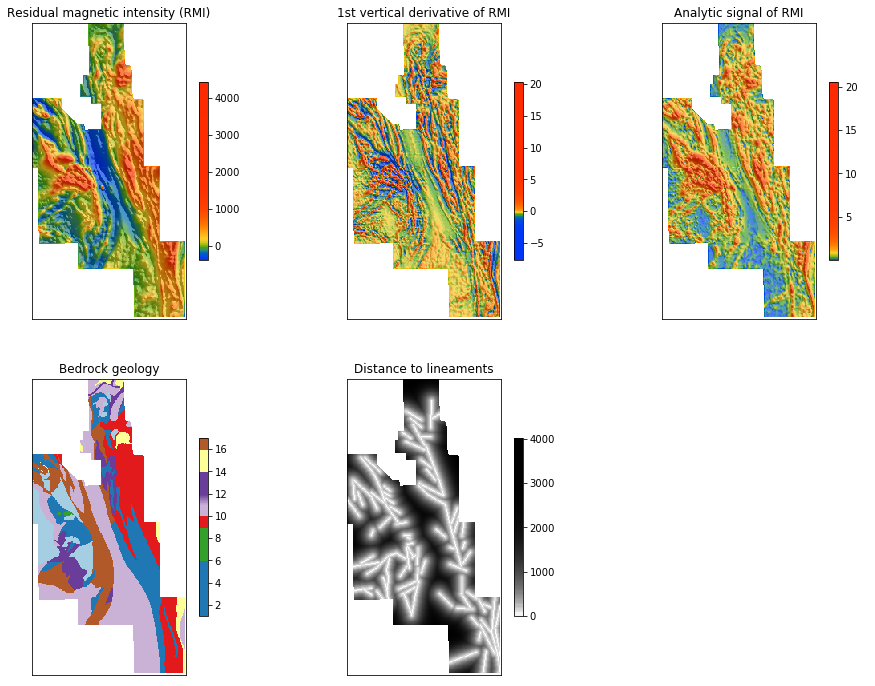

In [28]:
fig, ax=plt.subplots(2,3,figsize=(16,12))
#-----
ax[0,0].set_title('Residual magnetic intensity (RMI)')
RMI_gr.show(hs=True, cmap='cet_rainbow', ax=ax[0,0])
ax[0,1].set_title('1st vertical derivative of RMI')
vd_gr.show(hs=True, cmap='cet_rainbow', ax=ax[0,1])
ax[0,2].set_title('Analytic signal of RMI')
AS_gr.show(hs=True, cmap='cet_rainbow', ax=ax[0,2])
ax[1,0].set_title('Bedrock geology')
Geol_gr.show(hs=False, cmap='Paired', ax=ax[1,0])
ax[1,1].set_title('Distance to lineaments')
lin_gr.show(hs=False, cmap='gray_r', ax=ax[1,1])
#----
for axi in ax.ravel():
    axi.set_xticks([])
    axi.set_yticks([])
ax[1,2].axis('off')

plt.show()

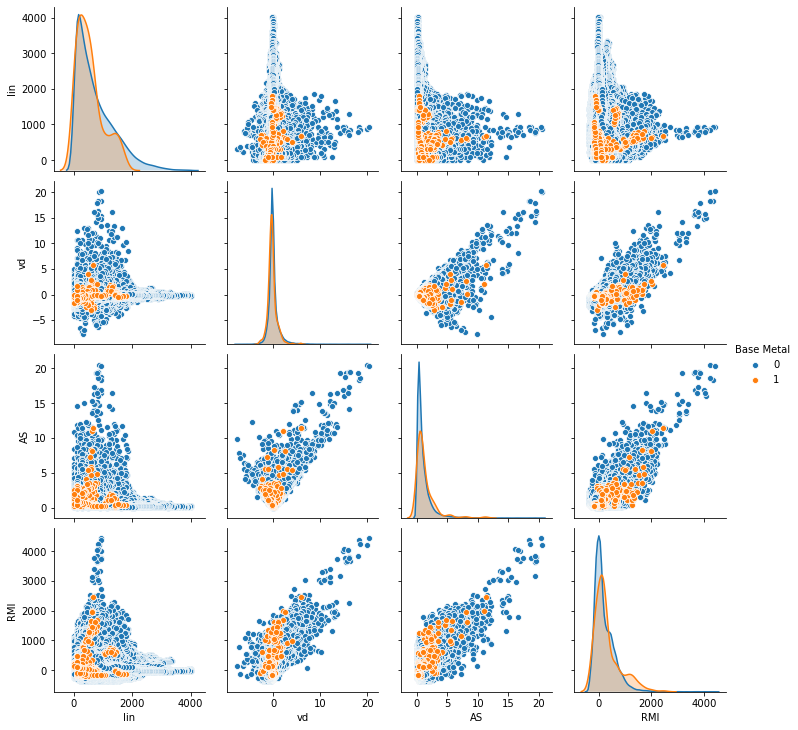

In [29]:
sns.pairplot(df, vars=['lin','vd','AS','RMI'], hue='Base Metal')

# Unsupervised classification
The objective of the work is to delineate areas with high potential for mineral exploration. The problem can be framed as a supervised or unsupervised task. 

In the unsupervised approach, data (excluding mineral indices) can be grouped in a number of clusters.
The resultant clusters will be mapped against mineral indices. The proportion of mineral indices in each cluster determines how prospective the cluster is. The cluster(s) containing majority of mineral indices can be introduced as a more prospective clusters which delineate areas with higher potential for mineral exploration.

### KMeans

In [30]:
from sklearn.cluster import KMeans

In [31]:
# data are scaled to be used by the Kmeans algorithm 
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(df_aoi[['Geol', 'lin', 'vd', 'AS', 'RMI']]), 
                          columns=['Geol', 'lin', 'vd', 'AS', 'RMI'], index=df_aoi.index)

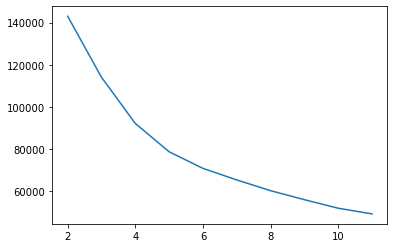

In [75]:
# find the optimal number of clusters based  on the 'elbow method'
k_inertia=[]
for n_cluster in range (2,12):
    km_cluster=KMeans(n_clusters=n_cluster)
    km_cluster.fit(data_scaled)
    k_inertia.append(km_cluster.inertia_)
    
plt.plot(range(2,12), k_inertia)

In [33]:
# the optimal number of clusters was determined to be 5
km_cluster=KMeans(n_clusters=5)
df_aoi['Cluster_km']=km_cluster.fit_predict(data_scaled)
df.drop('Cluster_km', axis=1, errors='ignore', inplace=True)
df=pd.merge(df, df_aoi[['Cluster_km']], how='left', left_index=True, right_index=True)

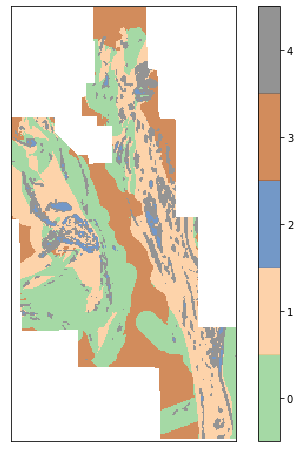

In [34]:
plt.figure(figsize=(8,8))
im=plt.imshow(np.ma.masked_array(np.array(df['Cluster_km']).reshape(371,192),mask),cmap=plt.cm.get_cmap('Accent', 5), alpha=0.7)

c_bar = plt.colorbar(im, ticks=[0, 1, 2, 3, 4])
plt.clim(-0.5, 4.5)
plt.xticks([]); plt.yticks([]);

Cluster 1 represents the largest proportion of known mineral indices

In [35]:
df.groupby(by='Cluster_km').sum()[['Gold','Base Metal']]

,Gold,Base Metal
Cluster_km,,
0.0,70,65
1.0,174,115
2.0,4,7
3.0,4,24
4.0,37,49


# Binary classification
The second approach is to think of the problem as a supervised task. A model is trained on variables to label the data as target and non-target data (binary classification). There are some factors that should be considered:

1) Due to different geological cgaracteristics, models must be trained separately for Base Metal deposits and Gold deposits.

2) Areas indicated by mineral indices are used as targets (labeled as 1); The areas for which mineral indices is 0 can be barren (non-target), but might be an under-explored area as well. 

3) The data is significantly imbalanced with only 2% of the data labeled as 1.

4) The model can be trained, then applied to a new area (new study area or an area excluded from modeling process). During the training, it is important have high value for True Positive. Increasing the recall will result in high number of False Positive. False Positives might represent under-explored, prospective areas (initially labelled as 0 (barren), but predicted as 1 by the model). So, a map showing areas predicted as target (True positive and False positive) would be a valuable product from this work.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [37]:
# scale the data for classification
scaler_cl=StandardScaler()

# create dummy variables from the column 'Geol'
dummies_df_aoi=pd.get_dummies(df_aoi[['Geol', 'lin', 'vd', 'AS', 'RMI']],columns=['Geol'])
data_scaled_cl=pd.DataFrame(scaler_cl.fit_transform(dummies_df_aoi), 
                          columns=dummies_df_aoi.columns, index=df_aoi.index)

#### There are a number of ways to deal with imbalanced data such as under-sampling (reduces class 0 size) and oversampling (increases class 1 size). SMOTETomek combines under- and over-sampling by increasing the class 1, then reduces the size of both classes. It is critical to make sure that all under-over sampling process is applied only to training data (not the test data).

Here is what happens within the data_prep function:

1) The variable com_col specifies whether the model is trained for Gold or Base Metal

2) Train and test dataset are created. The parameter stratify is set to 'y' to make sure 30 % of 1s are in the test data for a reliable evaluation.

3) SMOTETomek is implemented on the training set to balance the data.

4) The function returns three variables:

    XX: a dataframe contains oversampled training data and test data (variables excluding the target variable)

    yy: a dataframe contains oversampled training data and test data (only the target)

    pds: an array indicating indices of test data to be used for k-fold cross validation in Gridsearch


In [38]:
def data_prep(com_col):
    X=data_scaled_cl
    y=df_aoi[com_col]
    # split the dataset ino train and test sets
    X_train, X_test, y_train, y_test= train_test_split(X, y,stratify=y, test_size=0.3)
    
    smt = SMOTETomek(sampling_strategy='auto')
    X_train, y_train = smt.fit_sample(X_train, y_train) # i
    
    # SMOTETomek resets the index column of the training data, before merging them, 
    # before resetting the index column, index column of the test data should be reset as well. 
    # the indices are stored to be used later in plotting ROC curve
    original_test_index= X_test.index
    X_test.index=range(len(X_train),len(X_train)+len(X_test))
    y_test.index=range(len(X_train),len(X_train)+len(X_test))
    
    # the train and test datasets need to be merged to be used as an input for GridSearch
    XX=pd.concat([X_train,X_test])
    yy=pd.concat([y_train,y_test])
    
    # Provides train/test indices to split data into train/test sets using a predefined scheme specified by the user 
    # here, only X_test and y_test are used for testing the model to avoid using oversampled X_train/y_train data.
    split_index = [-1 if x in X_train.index else 0 for x in XX.index]
    pds = PredefinedSplit(test_fold = split_index)
    return XX, yy, pds, original_test_index

In [39]:
# implement data preparation for Gold and Base Metal
X_bs, y_bs, pds_bs, test_idx_bs= data_prep('Base Metal')
X_gold, y_gold, pds_gold, test_idx_gold= data_prep('Gold')

# Define a classifier

In [40]:
#--- Random Forest 
rfc=RandomForestClassifier()

rf_parameters=param_grid = {
    'max_depth': [8,10],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [10, 20],
    'n_estimators': [100, 150, 200],
    'class_weight':[{0:1,1:w} for w in [4, 6 , 8, 10]]}

Classifier hyperparameters are tuned through GridSearch.

Although the dataset was balanced by SMOTETomek, class weights were used to assign higher value to the instances of class1 in the loss function (the loss becomes a weighted average).

Note that the evaluation is conducted on test data which is still an imbalanced dataset for which f1_weighted is recommended scorer to be used for model evaluation. 

## Gold

In [41]:
grid_search_gold = GridSearchCV(estimator = rfc, cv=pds_gold, param_grid=rf_parameters, scoring='f1_weighted')

# fit the model
grid_search_gold.fit(X_gold, y_gold) 

print ('Best f1_weighted_score: {:.2f} %'.format(grid_search_gold.best_score_))
print('Best_parameters: ', grid_search_gold.best_params_)

Best f1_weighted_score: 0.86 %
Best_parameters:  {'class_weight': {0: 1, 1: 4}, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 150}


In [42]:
# make prediction for all data using the best model parameters

df_aoi['rf_Gold']=grid_search_gold.best_estimator_.predict(data_scaled_cl)
df.drop('rf_Gold', axis=1, errors='ignore', inplace=True)
df=pd.merge(df, df_aoi['rf_Gold'], how='left', left_index=True, right_index=True)

In [43]:
# confusion matrix for test data
print('test data:\n', confusion_matrix(df_aoi.loc[test_idx_gold]['Gold'],df_aoi.loc[test_idx_gold]['rf_Gold']))
# confusion matrix for all data
print('\n all data:\n',confusion_matrix(df_aoi['Gold'],df_aoi['rf_Gold']))

test data:
 [[8852 2501]
 [   2   85]]

 all data:
 [[29385  8459]
 [    3   286]]


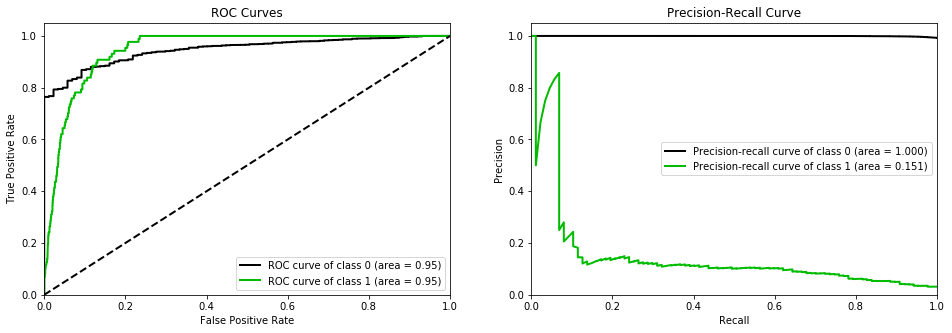

In [70]:
y_gold_probas = grid_search_gold.best_estimator_.predict_proba(data_scaled_cl.loc[test_idx_gold].values)

y_gold_true=df_aoi.loc[test_idx_gold]['Gold'].values

fig, axes= plt.subplots(1, 2, figsize=(16,5))

skplt.metrics.plot_roc_curve(y_true= y_gold_true , y_probas=y_gold_probas, curves=('each_class'), ax=axes[0])
skplt.metrics.plot_precision_recall_curve(y_true= y_gold_true, y_probas=y_gold_probas, curves=('each_class'),ax=axes[1])
plt.show()

#### ROC finds whether a classifier is able to beat a random guess
Using ROC for imbalanced data can sometimes be deceptive. 

#### Rapid decrease in False Positive Rate compared to True Positive Rate is due to the high number of True Negatives. 

#### Sharp drop in Precision-Recall curve indicates that the model readily sacrifices precision to achieve greater recall.

### Base Metal

In [46]:
grid_search_bs = GridSearchCV(estimator = rfc, cv=pds_bs, param_grid=rf_parameters, scoring='f1_weighted')

# Fit the model and find the best parameters
grid_search_bs.fit(X_bs, y_bs) 

print ('Best f1_weighted_score: {:.2f} %'.format(grid_search_bs.best_score_))
print('Best_parameters: ', grid_search_bs.best_params_)

Best f1_weighted_score: 0.85 %
Best_parameters:  {'class_weight': {0: 1, 1: 4}, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [47]:
# use the best model to make prediction for all data
df_aoi['rf_BaseMetal']=grid_search_bs.best_estimator_.predict(data_scaled_cl)
df.drop('rf_BaseMetal', axis=1, errors='ignore', inplace=True)
df=pd.merge(df, df_aoi['rf_BaseMetal'], how='left', left_index=True, right_index=True)

In [48]:
# confusion matrix for test data
print('test data:\n', confusion_matrix(df_aoi.loc[test_idx_bs]['Base Metal'],df_aoi.loc[test_idx_bs]['rf_BaseMetal']))
# confusion matrix for all data
print('\n\n all data:\n',confusion_matrix(df_aoi['Base Metal'],df_aoi['rf_BaseMetal']))

test data:
 [[8826 2536]
 [  12   66]]


 all data:
 [[29276  8597]
 [   13   247]]


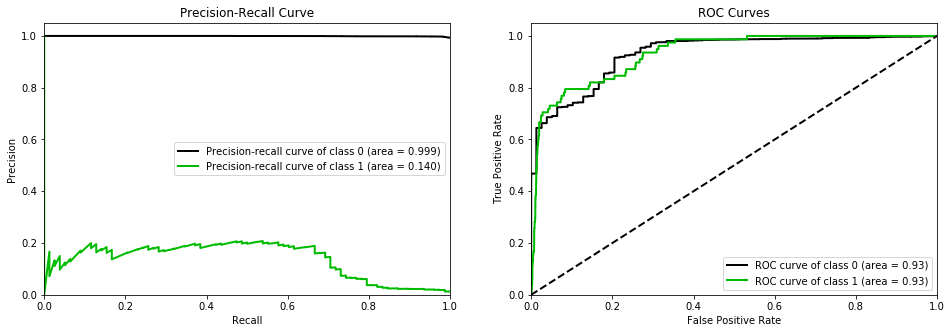

In [49]:
y_bs_probas = grid_search_bs.best_estimator_.predict_proba(data_scaled_cl.loc[test_idx_bs])
y_bs_true=df_aoi.loc[test_idx_bs]['Base Metal'].values

fig, axes= plt.subplots(1, 2, figsize=(16,5))
skplt.metrics.plot_precision_recall_curve(y_true= y_bs_true , y_probas=y_bs_probas,curves=('each_class'), ax=axes[0])
skplt.metrics.plot_roc_curve(y_true=y_bs_true, y_probas=y_bs_probas, curves=('each_class'), ax=axes[1])

plt.show()

## plot the potential maps

#### The maps delineate areas that are predicted as propspective areas by the model

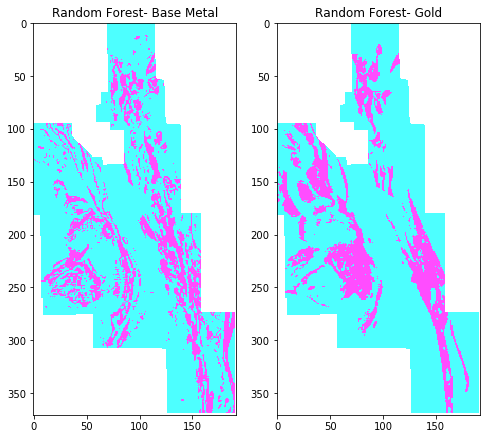

In [50]:
fig, axes=plt.subplots(1,2, figsize=(8,8))

axes[0].imshow(np.ma.masked_array(np.array(df['rf_BaseMetal']).reshape(371,192),mask),cmap=plt.cm.get_cmap('cool', 2), 
            alpha=0.7,label=[df['rf_BaseMetal'].unique()])
axes[0].set_title('Random Forest- Base Metal')

axes[1].imshow(np.ma.masked_array(np.array(df['rf_Gold']).reshape(371,192),mask),cmap=plt.cm.get_cmap('cool', 2), 
            alpha=0.7,label=[df['rf_Gold'].unique()])
axes[1].set_title('Random Forest- Gold')
plt.show()

## feature importance
#### Feature importance is a score assigned to each input featur based on how useful they are at predicting a target variable

In [51]:
feat_importance_bs=pd.DataFrame(dict(zip(data_scaled_cl.columns, grid_search_bs.best_estimator_.feature_importances_)).items(), columns=['feature', 'importance'])
feat_importance_gold=pd.DataFrame(dict(zip(data_scaled_cl.columns, grid_search_gold.best_estimator_.feature_importances_)).items(), columns=['feature', 'importance'])

 #### RMI and distance to lineaments are two most important features for Base Metal potential mapping

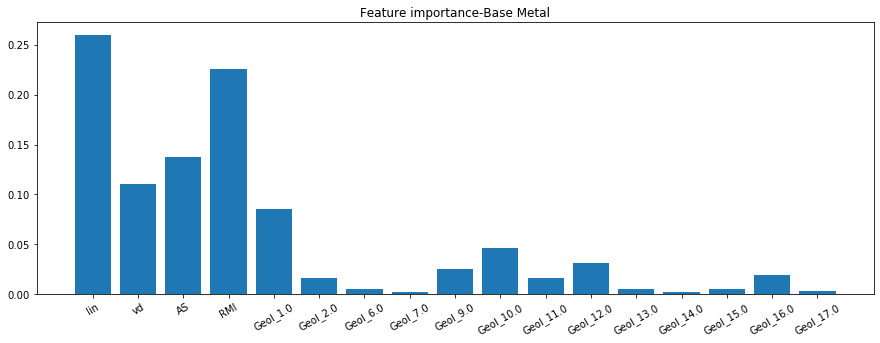

In [52]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=30)
plt.title('Feature importance-Base Metal')
plt.bar(x=feat_importance_bs['feature'], height=feat_importance_bs['importance'])
plt.show()

#### For Gold deposits, in addition to RMI and distance to lineaments, two rock types show high importance values.
#### It suggests that host rocks have more influence in finding Gold deposits compared to Base Metal deposits. 

Geol_10: Strongly foliated and refolded granodioritic-granitic gneisses

Geol_9: Psammitic meta-arkose, arkosic wacke, and polymictic meta-arkose conglomer

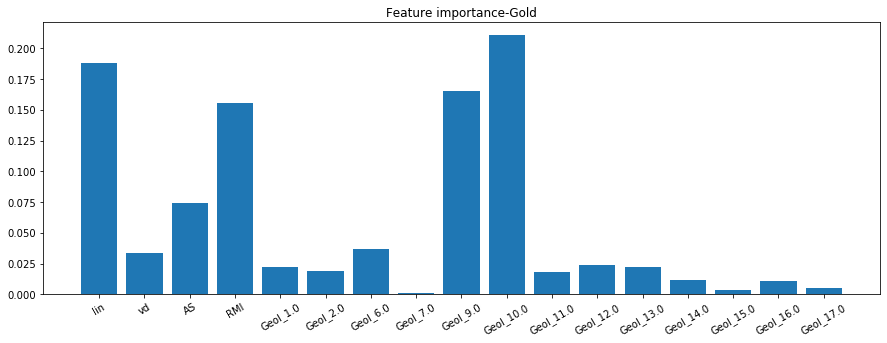

In [53]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=30)
plt.title('Feature importance-Gold')
plt.bar(x=feat_importance_gold['feature'], height=feat_importance_gold['importance'])
plt.show()